# Extrinsic Calibration from Point-Line-Line Correspondences

### Goal

Consider a 3D point $X$ and two 3D lines $L'$ and $L''$ passing through (intersecting at) $X$.
Given the 2D projection of $X$ to the first camera $C$ as $x$, and the projections of $L'$ and $L''$ to the second and the third cameras $C'$ and $C''$ as $\ell'$ and $\ell''$ respectively, this notebook estimates the relative poses of the cameras using the trifocal tensor.

* Input
  * $x$: 2D point in $C$ image
  * $\ell'$: 2D line in $C'$ image
  * $\ell''$: 2D line in $C''$ image
  * $K, K', K''$: intrinsic parameters
* Output
  * $R', R'', t', t''$: Relative pose satisfying $X' = R' X + t'$ (i.e., $C$ is the world coordinate system)


Note:
1. $C, C', C''$ should not be in a collinear position.

## Libraries

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pycalib
from pycalib.plot import plotCamera
from pycalib.calib import lookat
import scipy as sp


## Synthetic data



In [2]:
np.random.seed(0)
SIGMA = 0.01 # pixel noise

# 3D points
# X_gt = (np.random.rand(16, 3) - 0.5)*5 + [0, 0, 10] # random points centered at [0, 0, 10]
X_gt = np.array(np.meshgrid(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5), np.linspace(9, 11, 3))).reshape((3, -1)).T  # 3D grid points

# 3D line directions
L1_gt = np.random.randn(len(X_gt), 3)
L1_gt = L1_gt / np.linalg.norm(L1_gt, axis=1)[:,None]
L2_gt = np.random.randn(len(X_gt), 3)
L2_gt = L2_gt / np.linalg.norm(L2_gt, axis=1)[:,None]
L3_gt = np.random.randn(len(X_gt), 3)
L3_gt = L3_gt / np.linalg.norm(L3_gt, axis=1)[:,None]

# Camera poses
R1_gt = np.eye(3)
t1_gt = np.zeros(3).reshape((3,1))
R2_gt, t2_gt = lookat(np.array([1,-1,1]), np.array([0,0,10]), np.array([0,1,0]))
R3_gt, t3_gt = lookat(np.array([-2,1,-1]), np.array([0,0,10]), np.array([0,1,0]))
rvec1_gt = cv2.Rodrigues(R1_gt)[0]
rvec2_gt = cv2.Rodrigues(R2_gt)[0]
rvec3_gt = cv2.Rodrigues(R3_gt)[0]

# Camera intrinsics
K1_gt = np.array([[600, 0, 320], [0, 600, 240], [0, 0, 1]]).astype(np.float64)  # VGA camera
K2_gt = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]]).astype(np.float64)  # 720p camera
K3_gt = np.array([[600, 0, 512], [0, 600, 768/2], [0, 0, 1]]).astype(np.float64)  # XGA camera

# Projection matrices
P1_gt = K1_gt @ np.hstack([R1_gt, t1_gt])
P2_gt = K2_gt @ np.hstack([R2_gt, t2_gt])
P3_gt = K3_gt @ np.hstack([R3_gt, t3_gt])
assert P1_gt.shape == P2_gt.shape == P3_gt.shape == (3, 4)

# 2D corresponding points
x1_gt = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))
x2_gt = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))
x3_gt = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))
x1h_gt = cv2.convertPointsToHomogeneous(x1_gt)
x2h_gt = cv2.convertPointsToHomogeneous(x2_gt)
x3h_gt = cv2.convertPointsToHomogeneous(x3_gt)

x1_d = x1_gt + np.random.normal(scale=SIGMA, size=x1_gt.shape)
x2_d = x2_gt + np.random.normal(scale=SIGMA, size=x2_gt.shape)
x3_d = x3_gt + np.random.normal(scale=SIGMA, size=x3_gt.shape)
x1h_d = cv2.convertPointsToHomogeneous(x1_d)
x2h_d = cv2.convertPointsToHomogeneous(x2_d)
x3h_d = cv2.convertPointsToHomogeneous(x3_d)

# 2D lines, lab = projection of Lb to Ca
l11_gt = np.cross(x1h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l12_gt = np.cross(x1h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l13_gt = np.cross(x1h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l21_gt = np.cross(x2h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l22_gt = np.cross(x2h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l23_gt = np.cross(x2h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l31_gt = np.cross(x3h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))
l32_gt = np.cross(x3h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))
l33_gt = np.cross(x3h_gt, cv2.convertPointsToHomogeneous(cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))

l11_d = np.cross(x1h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x1_gt.shape) + cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l12_d = np.cross(x1h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x1_gt.shape) + cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l13_d = np.cross(x1h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x1_gt.shape) + cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1_gt, None)[0].reshape((-1, 2))))
l21_d = np.cross(x2h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x2_gt.shape) + cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l22_d = np.cross(x2h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x2_gt.shape) + cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l23_d = np.cross(x2h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x2_gt.shape) + cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2_gt, None)[0].reshape((-1, 2))))
l31_d = np.cross(x3h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x3_gt.shape) + cv2.projectPoints((X_gt + L1_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))
l32_d = np.cross(x3h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x3_gt.shape) + cv2.projectPoints((X_gt + L2_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))
l33_d = np.cross(x3h_d, cv2.convertPointsToHomogeneous(np.random.normal(scale=SIGMA, size=x3_gt.shape) + cv2.projectPoints((X_gt + L3_gt).reshape((-1, 1, 3)), rvec3_gt, t3_gt, K3_gt, None)[0].reshape((-1, 2))))

# Verify triangulation
Y = cv2.triangulatePoints(P1_gt, P2_gt, x1_gt.T, x2_gt.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)
Y = cv2.triangulatePoints(P2_gt, P3_gt, x2_gt.T, x3_gt.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)
Y = cv2.triangulatePoints(P3_gt, P1_gt, x3_gt.T, x1_gt.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)

# Verify z > 0 at each camera
assert np.all(X_gt[:, 2] > 0)
assert np.all((R2_gt @ X_gt.T + t2_gt)[2, :] > 0)
assert np.all((R3_gt @ X_gt.T + t3_gt)[2, :] > 0)

# Verify x1 is on l1?, x2 is on l2?, x3 is on l3?
assert np.allclose(np.einsum('ij,ij->i', l11_gt.reshape((-1, 3)), x1h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l12_gt.reshape((-1, 3)), x1h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l13_gt.reshape((-1, 3)), x1h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l21_gt.reshape((-1, 3)), x2h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l22_gt.reshape((-1, 3)), x2h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l23_gt.reshape((-1, 3)), x2h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l31_gt.reshape((-1, 3)), x3h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l32_gt.reshape((-1, 3)), x3h_gt.reshape((-1, 3))), 0)
assert np.allclose(np.einsum('ij,ij->i', l33_gt.reshape((-1, 3)), x3h_gt.reshape((-1, 3))), 0)

# 3D planes backprojected thgouth 2D lines. Ca and Lb is on Sab.
S11_gt = (P1_gt.T @ l11_gt.reshape((-1, 3)).T).T
S12_gt = (P1_gt.T @ l12_gt.reshape((-1, 3)).T).T
S13_gt = (P1_gt.T @ l13_gt.reshape((-1, 3)).T).T
S21_gt = (P2_gt.T @ l21_gt.reshape((-1, 3)).T).T
S22_gt = (P2_gt.T @ l22_gt.reshape((-1, 3)).T).T
S23_gt = (P2_gt.T @ l23_gt.reshape((-1, 3)).T).T
S31_gt = (P3_gt.T @ l31_gt.reshape((-1, 3)).T).T
S32_gt = (P3_gt.T @ l32_gt.reshape((-1, 3)).T).T
S33_gt = (P3_gt.T @ l33_gt.reshape((-1, 3)).T).T

# Verify the intersection of S11, S21, S31 is L1
assert np.allclose(np.einsum('ij,ij->i', S11_gt[:,:3], L1_gt), 0), "L1 is on S11"
assert np.allclose(np.einsum('ij,ij->i', S12_gt[:,:3], L2_gt), 0), "L2 is on S12"
assert np.allclose(np.einsum('ij,ij->i', S13_gt[:,:3], L3_gt), 0), "L3 is on S13"
assert np.allclose(np.einsum('ij,ij->i', S21_gt[:,:3], L1_gt), 0), "L1 is on S21"
assert np.allclose(np.einsum('ij,ij->i', S22_gt[:,:3], L2_gt), 0), "L2 is on S22"
assert np.allclose(np.einsum('ij,ij->i', S23_gt[:,:3], L3_gt), 0), "L3 is on S23"
assert np.allclose(np.einsum('ij,ij->i', S31_gt[:,:3], L1_gt), 0), "L1 is on S31"
assert np.allclose(np.einsum('ij,ij->i', S32_gt[:,:3], L2_gt), 0), "L2 is on S32"
assert np.allclose(np.einsum('ij,ij->i', S33_gt[:,:3], L3_gt), 0), "L3 is on S33"
assert np.allclose(np.einsum('ij,ij->i', S11_gt[:,:3], X_gt)+S11_gt[:,3], 0), "X is on S11"
assert np.allclose(np.einsum('ij,ij->i', S12_gt[:,:3], X_gt)+S12_gt[:,3], 0), "X is on S12"
assert np.allclose(np.einsum('ij,ij->i', S13_gt[:,:3], X_gt)+S13_gt[:,3], 0), "X is on S13"
assert np.allclose(np.einsum('ij,ij->i', S21_gt[:,:3], X_gt)+S21_gt[:,3], 0), "X is on S21"
assert np.allclose(np.einsum('ij,ij->i', S22_gt[:,:3], X_gt)+S22_gt[:,3], 0), "X is on S22"
assert np.allclose(np.einsum('ij,ij->i', S23_gt[:,:3], X_gt)+S23_gt[:,3], 0), "X is on S23"
assert np.allclose(np.einsum('ij,ij->i', S31_gt[:,:3], X_gt)+S31_gt[:,3], 0), "X is on S31"
assert np.allclose(np.einsum('ij,ij->i', S32_gt[:,:3], X_gt)+S32_gt[:,3], 0), "X is on S32"
assert np.allclose(np.einsum('ij,ij->i', S33_gt[:,:3], X_gt)+S33_gt[:,3], 0), "X is on S33"



## Trifocal Tensor

This cell verifies several constraints on the trifocal tensor, to make sure that the synthesized dataset is consistent.

- https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZtrifocal.pdf
- https://enpc.hal.science/hal-01700686/document


In [3]:
import itertools
from icecream import ic



def proj2tft(a, b, c):
    # Eq. (17.12) of H&Z

    # https://stackoverflow.com/a/55251676
    def mat_wo_row(m, remove_row_idx):
        return np.vstack((m[:remove_row_idx, :], m[remove_row_idx+1:,]))

    assert a.shape == b.shape == c.shape == (3,4)
    T = np.zeros((3,3,3))
    for i in range(3):
        for q in range(3):
            for r in range(3):
                T[i,q,r] = ((-1)**i) * np.linalg.det(np.vstack((mat_wo_row(a, i), b[q], c[r])))
    return T

def tft2epipoles(T):
    # Result 15.4 of H&Z
    #
    # The epipole e21 is the common intersection of the epipolar lines represented by the left null-vectors of the matrices T[i].
    # Similarly the epipole e31 is the common intersection of lines represented by the right null-vectors of the matrices T[i].

    def svec2epi(s1, s2, s3):
        u, d, vt = np.linalg.svd([s1[2], s2[2], s3[2]])
        return (vt[2] / vt[2,2]).reshape((3,1))

    assert T.shape == (3,3,3)
    u1, d1, vt1 = np.linalg.svd(T[0])
    u2, d2, vt2 = np.linalg.svd(T[1])
    u3, d3, vt3 = np.linalg.svd(T[2])

    e21 = svec2epi(u1.T, u2.T, u3.T)
    e31 = svec2epi(vt1, vt2, vt3)
    return e21, e31

def tft2fmat(T):
    # Eq. (15.8) of H&Z

    e21, e31 = tft2epipoles(T)
    F21 = pycalib.calib.skew(e21) @ np.einsum('ijk,k->ji',T,e31.flatten())
    F31 = pycalib.calib.skew(e31) @ np.einsum('ikj,k->ji',T,e21.flatten())
    F21 = F21 / F21[2,2]
    F31 = F31 / F31[2,2]
    return F21, F31

T_gt = proj2tft(P1_gt, P2_gt, P3_gt)

T = T_gt.copy()

e21, e31 = tft2epipoles(T)

# GT epipole in C2 and C3
e21_gt = K2_gt @ (R2_gt @ (- R1_gt @ t1_gt) + t2_gt)
e21_gt = e21_gt / e21_gt[2]
e31_gt = K3_gt @ (R3_gt @ (- R1_gt @ t1_gt) + t3_gt)
e31_gt = e31_gt / e31_gt[2]
assert np.allclose(e21, e21_gt)
assert np.allclose(e31, e31_gt)


# F21 satisfies x2.T @ F21 @ x1 = 0
# F31 satisfies x3.T @ F31 @ x1 = 0
F21, F31 = tft2fmat(T)

# GT Fmat
F21_gt, m21 = cv2.findFundamentalMat(x1_gt, x2_gt, cv2.FM_8POINT)
F31_gt, m31 = cv2.findFundamentalMat(x1_gt, x3_gt, cv2.FM_8POINT)
assert np.allclose(m21, 1)
assert np.allclose(m31, 1)
assert np.allclose(F21, F21_gt)
assert np.allclose(F31, F31_gt)

F21_gt = np.linalg.inv(K2_gt).T @ pycalib.calib.skew(R2_gt @ (- R1_gt @ t1_gt) + t2_gt) @ (R2_gt @ R1_gt.T @ np.linalg.inv(K1_gt))
F21_gt = F21_gt / F21_gt[2,2]
assert np.allclose(F21_gt, cv2.findFundamentalMat(x1_gt, x2_gt, cv2.FM_8POINT)[0])


# Trilinear constraint

# l-l-l (Table 15.3)
def tft_lll(T, l1, l2, l3):
    # l1 = l2 @ l3 @ T
    a = np.einsum('k,ijk->ij', l3.flatten(), T)
    a = np.einsum('j,ij->i', l2.flatten(), a)
    a = a / a[2]
    return np.cross(l1.flatten(), a.flatten())

# 3 projections of a single 3D line
for l1, l2, l3 in zip(l11_gt, l21_gt, l31_gt):
    assert np.allclose(tft_lll(T, l1, l2, l3), 0)
for l1, l2, l3 in zip(l12_gt, l22_gt, l32_gt):
    assert np.allclose(tft_lll(T, l1, l2, l3), 0)
for l1, l2, l3 in zip(l13_gt, l23_gt, l33_gt):
    assert np.allclose(tft_lll(T, l1, l2, l3), 0)

# p-l-l (Table 15.3)
def tft_pll(T, p1, l2, l3):
    a = np.einsum('k,ijk->ij', l3.flatten(), T)
    a = np.einsum('j,ij->i', l2.flatten(), a)
    a = a / a[2]
    p1 = p1.flatten()
    e = np.dot(p1/p1[2], a)
    return e

# matrix version
def tft_pll(T, p1, l2, l3):
    a = T[0] @ l3.reshape((3,1))
    b = T[1] @ l3.reshape((3,1))
    c = T[2] @ l3.reshape((3,1))
    l3T = np.hstack([a, b, c]).T
    l2l3T = l3T @ l2.reshape((3, 1))
    l2l3T = l2l3T.flatten()
    p1 = p1.flatten()
    e = np.dot(p1/p1[2], l2l3T/l2l3T[2])
    return e

# tensor version
def tft_pll(T, p1, l2, l3):
    p1 = p1.flatten()
    l2 = l2.flatten()
    l3 = l3.flatten()
    p1 = p1 / p1[2]
    l2 = l2 / l2[2]
    l3 = l3 / l3[2]

    X = T.copy()
    X = X / X[2,2,2]
    X[0,:,:] = p1[0] * X[0,:,:]
    X[1,:,:] = p1[1] * X[1,:,:]
    X[2,:,:] = p1[2] * X[2,:,:]
    X[:,0,:] = l2[0] * X[:,0,:]
    X[:,1,:] = l2[1] * X[:,1,:]
    X[:,2,:] = l2[2] * X[:,2,:]
    X[:,:,0] = l3[0] * X[:,:,0]
    X[:,:,1] = l3[1] * X[:,:,1]
    X[:,:,2] = l3[2] * X[:,:,2]
    return np.sum(X)

# tensor by outer product
def tft_pll(T, p1, l2, l3):
    p1 = p1.flatten()
    l2 = l2.flatten()
    l3 = l3.flatten()
    p1 = p1 / np.linalg.norm(p1)
    l2 = l2 / np.linalg.norm(l2)
    l3 = l3 / np.linalg.norm(l3)
    X = np.outer(p1, np.outer(l2, l3)).reshape(3,3,3)
    return np.sum(X * T / T[2,2,2])

# tensor by outer product v2
def tft_pll(T, p1, l2, l3):
    p1 = p1.flatten()
    l2 = l2.flatten()
    l3 = l3.flatten()
    p1 = p1 / np.linalg.norm(p1)
    l2 = l2 / np.linalg.norm(l2)
    l3 = l3 / np.linalg.norm(l3)
    X = np.einsum('i,j,k->ijk', p1, l2, l3)
    return np.sum(X * T / T[2,2,2])

# 2 projections of a single 3D line and a projection of a 3D point on the line
for p1, l2, l3 in zip(x1h_gt, l21_gt, l31_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l22_gt, l32_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l23_gt, l33_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)

# 2 projections of two 3D lines and the projection of their intersection
for p1, l2, l3 in zip(x1h_gt, l21_gt, l32_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l21_gt, l33_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l22_gt, l31_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l22_gt, l33_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l23_gt, l31_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)
for p1, l2, l3 in zip(x1h_gt, l23_gt, l32_gt):
    assert np.allclose(tft_pll(T, p1, l2, l3), 0)


## Trifocal Tensor from P-L-L correspondences

* Input
  * $x$: 2D point in $C$ image
  * $\ell'$: 2D line in $C'$ image
  * $\ell''$: 2D line in $C''$ image
  * $K, K', K''$: intrinsic parameters
* Output
  * $\mathcal{T}$: Trifocal tensor

Trilinear constraint

\begin{equation}
x^i \ell'_j \ell''_k \mathcal{T}_i^{jk} = 0\,,
\end{equation}

can be rewritten explicitly as

\begin{equation}
\begin{split}
\begin{bmatrix}
x_0 \ell'_0 \ell''_0 & \cdots & x_i \ell'_j \ell''_k & \cdots & x_2 \ell'_2 \ell''_2
\end{bmatrix}
\begin{bmatrix}
t_{000} \\
\vdots \\
t_{ijk} \\
\vdots \\
t_{222}
\end{bmatrix}
=0 \\
\Leftrightarrow \boldsymbol{a}^\top \boldsymbol{t} = 0 \,,
\end{split}
\end{equation}

where $\boldsymbol{t}$ is the flattened trifocal tensor as a 27-dim vector.  By stacking this constraint from each PLL constraint, we have a linear system of the form $A \boldsymbol{t} = 0$ and can obtain the solution as the right singular vector corresponding to the smallest (ideally zero) singular value.


In [4]:
def pll2tft(p1, l2, l3):
    p1 = np.squeeze(p1)
    l2 = np.squeeze(l2)
    l3 = np.squeeze(l3)
    assert p1.shape == l2.shape == l3.shape
    assert p1.shape[1] == 3

    p1 = p1 / np.linalg.norm(p1, axis=1)[:,None]
    l2 = l2 / np.linalg.norm(l2, axis=1)[:,None]
    l3 = l3 / np.linalg.norm(l3, axis=1)[:,None]
    X = np.einsum('ai,aj,ak->aijk', p1, l2, l3).reshape((-1, 27))

    u, d, vt = np.linalg.svd(X)
    T = vt[-1].reshape((3,3,3))
    return T

T_est = pll2tft(x1h_gt, l21_gt, l32_gt)
assert np.allclose(T_est, T_gt / np.linalg.norm(T_gt))


## Pose from Trifocal Tensor

* Input
  * $x$: 2D point in $C$ image
  * $\ell'$: 2D line in $C'$ image
  * $\ell''$: 2D line in $C''$ image
  * $K, K', K''$: intrinsic parameters
  * $\mathcal{T}$: Trifocal tensor
* Output
  * $R', R'', t', t''$: Relative pose satisfying $X' = R' X + t'$ (i.e., $C$ is the world coordinate system)
  * $X$: 3D point triangulated from $x, \ell', \ell''$



In [5]:
def e2rt_pl(E21, K1, K2, p1, l2):
    """
    Given an essentinal matrix $E$, we have four possible solutions
    * $R, t$,
    * $R, -t$,
    * $R', t$, and
    * $R', -t$.
    """

    def z_count(R2, t2, n1, K2, l2):
        """
        Count number of points appeared in front of the cameras
        """

        # projection matrix
        P2 = K2 @ np.hstack([R2, t2.reshape((3,1))])

        # 3D planes backprojected through l2
        S2 = (P2.T @ l2.reshape((-1, 3)).T).T # Nx4

        # X = d * n1 is on S2
        d = - S2[:,3] / np.einsum('ij,ij->i', S2[:,:3], n1) # N
        X = n1*d[:,None]
        p2 = R2 @ X.T + t2.reshape((3,1))

        return np.sum(d>0) + np.sum(p2[2,:]>0), X

    p1 = np.squeeze(p1)
    l2 = np.squeeze(l2)
    R2a, R2b, t2 = cv2.decomposeEssentialMat(E21)
    n1 = (np.linalg.inv(K1) @ p1.T).T # Nx3

    zmax = -1
    for R2x, t2x in [[R2a, t2], [R2a, -t2], [R2b, t2], [R2b, -t2]]:
        z, Xx = z_count(R2x,  t2x, n1, K2, l2)
        if zmax < z:
            zmax = z
            R2_est = R2x
            t2_est = t2x
            X_est = Xx

    return R2_est, t2_est, X_est

def tft2rt_pll(T, K1, K2, K3, x1, l2, l3):
    x1 = np.squeeze(x1)
    l2 = np.squeeze(l2)
    l3 = np.squeeze(l3)
    assert x1.shape == l2.shape == l3.shape
    assert x1.shape[1] == 3

    # get F from T
    F21, F31 = tft2fmat(T)

    # get E from F
    E21 = K2.T @ F21 @ K1
    E31 = K3.T @ F31 @ K1

    # get R,t from E
    R2, t2, X2 = e2rt_pl(E21, K1, K2, x1, l2)
    R3, t3, X3 = e2rt_pl(E31, K1, K3, x1, l3)

    # X2 and X3 must be identical up to scale
    scale = np.sum(X2) / np.sum(X3)
    t3 = scale * t3
    X3 = scale * X3
    #assert np.allclose(X2, X3)

    return R2, t2, R3, t3, X2

R2, t2, R3, t3, X = tft2rt_pll(T_est, K1_gt, K2_gt, K3_gt, x1h_gt, l21_gt, l32_gt)

assert np.allclose(R2, R2_gt)
assert np.allclose(R3, R3_gt)
assert np.allclose(t2, t2_gt / np.linalg.norm(t2_gt))
assert np.allclose(t3, t3_gt / np.linalg.norm(t2_gt))


## Bundle Adjustment

In [ ]:
def reprojection_error_pll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, *, normalize=True):
    def proj(X, K, R, t):
        x = K @ (R @ X.T + t.reshape((3,1)))
        x = x / x[2,:]
        return x.T

    if normalize:
        x1 = x1.reshape((-1, 3))
        l2 = l2.reshape((-1, 3))
        l3 = l3.reshape((-1, 3))
        l2 = l2 / l2[:,2][:,None]
        l3 = l3 / l3[:,2][:,None]

    p1 = proj(X, K1, np.eye(3), np.zeros(3))
    p2 = proj(X, K2, R2, t2)
    p3 = proj(X, K3, R3, t3)
    e1 = (x1[:,:2] - p1[:,:2])
    e2 = np.einsum('ij,ij->i', p2, l2)
    e3 = np.einsum('ij,ij->i', p3, l3)
    return e1, e2, e3

def ba_pll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, *, verbose=0, max_nfev=None):
    def encode(X, R2, t2, R3, t3):
        x = []
        x.extend(cv2.Rodrigues(R2)[0].flatten().tolist())
        x.extend(t2.flatten().tolist())
        x.extend(cv2.Rodrigues(R3)[0].flatten().tolist())
        x.extend(t3.flatten().tolist())
        x.extend(X.flatten().tolist())
        return x

    def decode(x):
        x = np.array(x)
        R2 = cv2.Rodrigues(x[:3])[0]
        t2 = x[3:6]
        R3 = cv2.Rodrigues(x[6:9])[0]
        t3 = x[9:12]
        X = x[12:].reshape((-1, 3))
        return X, R2, t2.reshape((3,1)), R3, t3.reshape((3,1))

    def jac_sparsity(Nx):
        # m_x_n, m:observations, n:parameters
        m = Nx * 4 # p1x, p1y, l2, l3
        n = 12 + Nx * 3
        A = np.zeros((m, n))
        for i in range(Nx):
            A[2*i:2*i+2, 12+3*i:12+3*(i+1)] = 1 # X
            A[2*Nx+i, 0:6] = 1 # R2, t2
            A[2*Nx+i, 12+3*i:12+3*(i+1)] = 1 # X
            A[3*Nx+i, 6:12] = 1 # R3, t3
            A[3*Nx+i, 12+3*i:12+3*(i+1)] = 1 # X
        return A

    def objfun(x, K1, K2, K3, x1, l2, l3):
        X_, R2_, t2_, R3_, t3_ = decode(x)
        e1, e2, e3 = reprojection_error_pll(X_, R2_, t2_, R3_, t3_, K1, K2, K3, x1, l2, l3, normalize=False)
        return np.concatenate([e1.flatten(), e2, e3])

    x1 = np.squeeze(x1)
    l2 = np.squeeze(l2)
    l3 = np.squeeze(l3)
    l2 = l2 / l2[:,2][:,None]
    l3 = l3 / l3[:,2][:,None]

    rep0 = reprojection_error_pll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, normalize=False)
    x0 = encode(X, R2, t2, R3, t3)

    # double-check
    X_, R2_, t2_, R3_, t3_ = decode(x0)
    assert np.allclose(X, X_)
    assert np.allclose(R2, R2_)
    assert np.allclose(t2, t2_)
    assert np.allclose(R3, R3_)
    assert np.allclose(t3, t3_)

    A = jac_sparsity(len(X))
    #A = None
    ret = sp.optimize.least_squares(objfun, x0, args=(K1, K2, K3, x1, l2, l3), jac_sparsity=A, verbose=verbose, max_nfev=max_nfev)

    Xo, R2o, t2o, R3o, t3o = decode(ret['x'])
    rep = reprojection_error_pll(Xo, R2o, t2o, R3o, t3o, K1, K2, K3, x1, l2, l3, normalize=False)

    return Xo, R2o, t2o, R3o, t3o, rep


e1, e2, e3 = reprojection_error_pll(X, R2, t2, R3, t3, K1_gt, K2_gt, K3_gt, x1h_gt, l21_gt, l32_gt)
assert np.allclose(e1, 0)
assert np.allclose(e2, 0)
assert np.allclose(e3, 0)

Xo, R2o, t2o, R3o, t3o, rep = ba_pll(X, R2, t2, R3, t3, K1_gt, K2_gt, K3_gt, x1h_gt, l21_gt, l32_gt, verbose=2)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2880e-17                                    9.55e-07    
       1              2         3.9802e-19      6.25e-17       2.16e-08       6.91e-11    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 6.2880e-17, final cost 3.9802e-19, first-order optimality 6.91e-11.


## Noisy case

In [40]:
T_d = pll2tft(x1h_d, l21_d, l32_d)
R2i, t2i, R3i, t3i, Xi = tft2rt_pll(T_d, K1_gt, K2_gt, K3_gt, x1h_d, l21_d, l32_d)
Xo, R2o, t2o, R3o, t3o, rep = ba_pll(Xi, R2i, t2i, R3i, t3i, K1_gt, K2_gt, K3_gt, x1h_d, l21_d, l32_d, verbose=2, max_nfev=1000)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8322e+00                                    6.25e+01    
       1              2         1.8608e-01      8.65e+00       1.03e+00       6.55e+00    
       2              3         4.2703e-02      1.43e-01       2.65e-01       3.70e-01    
       3              4         4.2431e-02      2.72e-04       8.61e-03       4.27e-02    
       4              5         4.2314e-02      1.17e-04       3.59e-02       6.33e-01    
       5              6         4.2232e-02      8.23e-05       5.07e-03       1.55e-02    
       6              7         4.2224e-02      7.63e-06       2.25e-03       1.03e-01    
       7              8         4.2217e-02      7.29e-06       1.44e-03       1.40e-02    
       8              9         4.2210e-02      7.29e-06       2.23e-03       1.01e-01    
       9             10         4.2202e-02      7.17e-06       1.39e-03       1.33e-02    

In [ ]:
def reprojection_error_llll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, *, normalize=True):
    def proj(X, K, R, t):
        x = K @ (R @ X.T + t.reshape((3,1)))
        x = x / x[2,:]
        return x.T

    if normalize:
        x1 = x1.reshape((-1, 3))
        l2 = l2.reshape((-1, 3))
        l3 = l3.reshape((-1, 3))
        l2 = l2 / l2[:,2][:,None]
        l3 = l3 / l3[:,2][:,None]

    p1 = proj(X, K1, np.eye(3), np.zeros(3))
    p2 = proj(X, K2, R2, t2)
    p3 = proj(X, K3, R3, t3)
    e1 = (x1[:,:2] - p1[:,:2])
    e2 = np.einsum('ij,ij->i', p2, l2)
    e3 = np.einsum('ij,ij->i', p3, l3)
    return e1, e2, e3

def ba_pll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, *, verbose=0, max_nfev=None):
    def encode(X, R2, t2, R3, t3):
        x = []
        x.extend(cv2.Rodrigues(R2)[0].flatten().tolist())
        x.extend(t2.flatten().tolist())
        x.extend(cv2.Rodrigues(R3)[0].flatten().tolist())
        x.extend(t3.flatten().tolist())
        x.extend(X.flatten().tolist())
        return x

    def decode(x):
        x = np.array(x)
        R2 = cv2.Rodrigues(x[:3])[0]
        t2 = x[3:6]
        R3 = cv2.Rodrigues(x[6:9])[0]
        t3 = x[9:12]
        X = x[12:].reshape((-1, 3))
        return X, R2, t2.reshape((3,1)), R3, t3.reshape((3,1))

    def jac_sparsity(Nx):
        # m_x_n, m:observations, n:parameters
        m = Nx * 4 # p1x, p1y, l2, l3
        n = 12 + Nx * 3
        A = np.zeros((m, n))
        for i in range(Nx):
            A[2*i:2*i+2, 12+3*i:12+3*(i+1)] = 1 # X
            A[2*Nx+i, 0:6] = 1 # R2, t2
            A[2*Nx+i, 12+3*i:12+3*(i+1)] = 1 # X
            A[3*Nx+i, 6:12] = 1 # R3, t3
            A[3*Nx+i, 12+3*i:12+3*(i+1)] = 1 # X
        return A

    def objfun(x, K1, K2, K3, x1, l2, l3):
        X_, R2_, t2_, R3_, t3_ = decode(x)
        e1, e2, e3 = reprojection_error_pll(X_, R2_, t2_, R3_, t3_, K1, K2, K3, x1, l2, l3, normalize=False)
        return np.concatenate([e1.flatten(), e2, e3])

    x1 = np.squeeze(x1)
    l2 = np.squeeze(l2)
    l3 = np.squeeze(l3)
    l2 = l2 / l2[:,2][:,None]
    l3 = l3 / l3[:,2][:,None]

    rep0 = reprojection_error_pll(X, R2, t2, R3, t3, K1, K2, K3, x1, l2, l3, normalize=False)
    x0 = encode(X, R2, t2, R3, t3)

    # double-check
    X_, R2_, t2_, R3_, t3_ = decode(x0)
    assert np.allclose(X, X_)
    assert np.allclose(R2, R2_)
    assert np.allclose(t2, t2_)
    assert np.allclose(R3, R3_)
    assert np.allclose(t3, t3_)

    A = jac_sparsity(len(X))
    #A = None
    ret = sp.optimize.least_squares(objfun, x0, args=(K1, K2, K3, x1, l2, l3), jac_sparsity=A, verbose=verbose, max_nfev=max_nfev)

    Xo, R2o, t2o, R3o, t3o = decode(ret['x'])
    rep = reprojection_error_pll(Xo, R2o, t2o, R3o, t3o, K1, K2, K3, x1, l2, l3, normalize=False)

    return Xo, R2o, t2o, R3o, t3o, rep


e1, e2, e3 = reprojection_error_pll(X, R2, t2, R3, t3, K1_gt, K2_gt, K3_gt, x1h_gt, l21_gt, l32_gt)
assert np.allclose(e1, 0)
assert np.allclose(e2, 0)
assert np.allclose(e3, 0)

Xo, R2o, t2o, R3o, t3o, rep = ba_pll(X, R2, t2, R3, t3, K1_gt, K2_gt, K3_gt, x1h_gt, l21_gt, l32_gt, verbose=2)


## Plot

/tmp/ipykernel_310687/4204170469.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


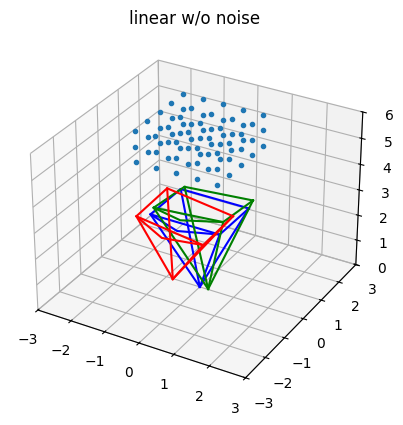

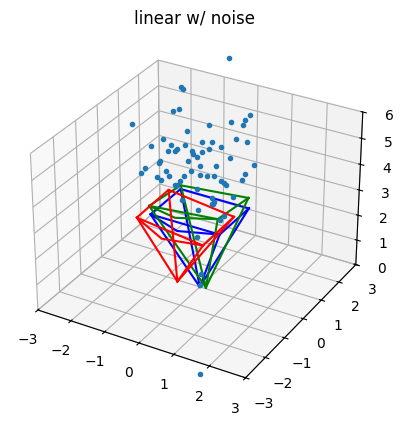

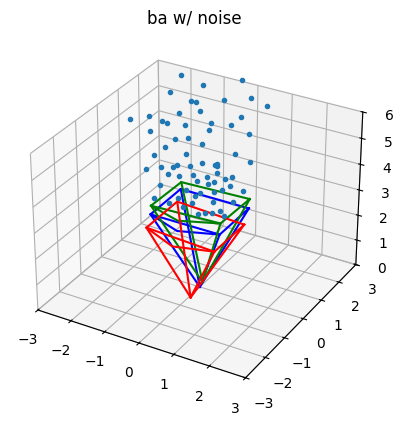

In [41]:
def plot(R2, t2, R3, t3, X, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    plotCamera(ax, np.eye(3), np.zeros(3), color="b", scale=1)
    plotCamera(ax, R2.T, - R2.T @ t2, color="g", scale=1)
    plotCamera(ax, R3.T, - R3.T @ t3, color="r", scale=1)
    ax.plot(X[:,0], X[:,1], X[:,2], ".")
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 6)
    ax.set_title(title)
    fig.show()

plot(R2, t2, R3, t3, X, 'linear w/o noise')
plot(R2i, t2i, R3i, t3i, Xi, 'linear w/ noise')
plot(R2o, t2o, R3o, t3o, Xo, 'ba w/ noise')
